In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
            SELECT CONVERT(DATE,CS.Process_Date) AS SUBMISSION_DATE,SUM(CS.Amt_Due) CHARGE_SUM
FROM CLAIMS_SUBMITTED AS CS
JOIN CLAIMS AS C ON C.Claim_No=CS.Claim_No
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT AND ISNULL(P.DELETED,0)=0
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,CS.Process_Date) BETWEEN '01-01-2020' AND '10-20-2022'
GROUP BY CONVERT(DATE,CS.Process_Date)
ORDER BY CONVERT(DATE,CS.Process_Date) ASC;
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [3]:
df=get_data()

In [4]:
data=df.copy
df.columns
df.shape

(1024, 2)

In [5]:
df.head()

,SUBMISSION_DATE,CHARGE_SUM
0,2020-01-01,3709368.6500
1,2020-01-02,5839172.7000
2,2020-01-03,4235575.5600
3,2020-01-04,218865.4000
4,2020-01-05,2166948.4100


In [6]:
df['SUBMISSION_DATE']=pd.to_datetime(df['SUBMISSION_DATE'])

In [7]:
claim_data=df[['SUBMISSION_DATE','CHARGE_SUM']]

In [8]:
claim_data.CHARGE_SUM = claim_data.CHARGE_SUM.apply(int)

In [9]:
# df[['CHARGE_SUM']].apply(int)

In [10]:
claim_data.head()

,SUBMISSION_DATE,CHARGE_SUM
0,2020-01-01,3709368
1,2020-01-02,5839172
2,2020-01-03,4235575
3,2020-01-04,218865
4,2020-01-05,2166948


In [11]:
claim_data = claim_data.rename(columns={'SUBMISSION_DATE': 'ds','CHARGE_SUM': 'y'})

In [12]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [13]:
claim_data.set_index('ds',inplace=True)

In [14]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [15]:
train.reset_index(inplace=True)
train.head(10)

,ds,y
0,2020-01-01,3709368
1,2020-01-02,5839172
2,2020-01-03,4235575
3,2020-01-04,218865
4,2020-01-05,2166948
5,2020-01-06,4703044
6,2020-01-07,3908514
7,2020-01-08,3149687
8,2020-01-09,4799008
9,2020-01-10,3440176


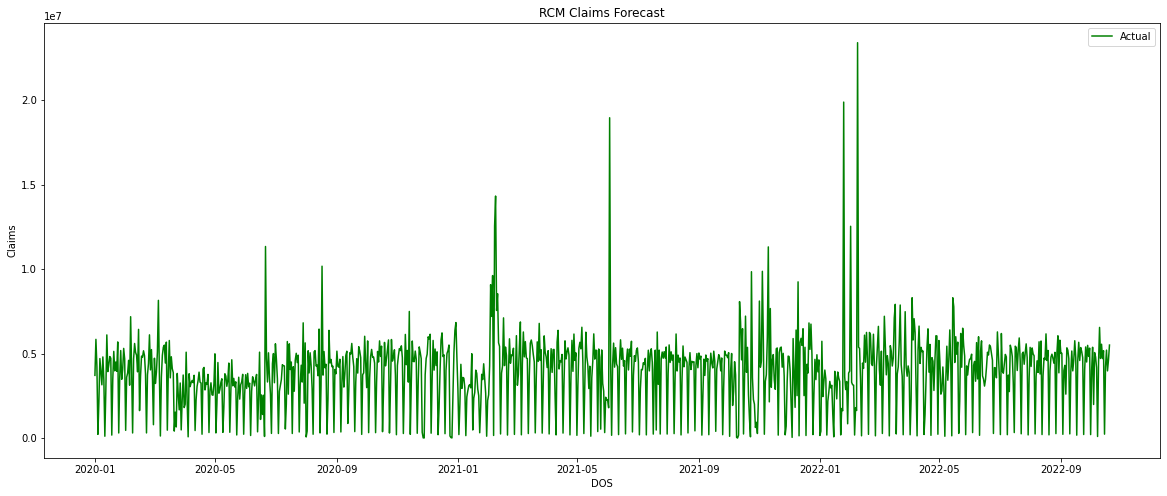

In [16]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [17]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [18]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,203977
1,2022-10-02,3980991
2,2022-10-03,5371517
3,2022-10-04,1985972
4,2022-10-05,5058575


In [19]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2020-01-01,3709368
1,2020-01-02,5839172
2,2020-01-03,4235575
3,2020-01-04,218865
4,2020-01-05,2166948


### Hyperparameter Tuning

In [20]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [21]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [22]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [23]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 125,
 'seasonality_mode': 'multiplicative'}

In [24]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.3,
                     holidays_prior_scale = 10,
                     n_changepoints = 25,
                     seasonality_mode = 'additive',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [25]:
my_model1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [26]:
filename = 'RCM_Prophet_Overall_Submission_Charges.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '09-20-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
15,2022-09-16,4694360.88970
16,2022-09-17,527469.64543
17,2022-09-18,3941867.26284
18,2022-09-19,5178653.57425
19,2022-09-20,4713322.69940


In [27]:
test=claim_data.loc['09-01-2022':'10-20-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '10-01-2022', end = '03-15-2023')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-10-16,4219352
2022-10-17,5201814
2022-10-18,3973605
2022-10-19,4619117
2022-10-20,5502317


In [28]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01,588586.56125,-2442947.77093,3527114.86703
1,2022-10-02,3991101.59658,1262530.02732,7015761.84481
2,2022-10-03,5212977.92555,2338235.11739,8270241.15996
3,2022-10-04,4729933.60126,1561610.68769,7780797.07202
4,2022-10-05,5038264.77443,2062604.22136,7948535.42323
5,2022-10-06,4767143.29993,1695762.95027,7699828.40235
6,2022-10-07,4691656.97362,1609016.16106,7619541.99279
7,2022-10-08,502143.52216,-2397976.29074,3589680.83451
8,2022-10-09,3892108.15643,821751.00929,6858288.10066
9,2022-10-10,4260989.54491,1240803.92481,7439111.36588


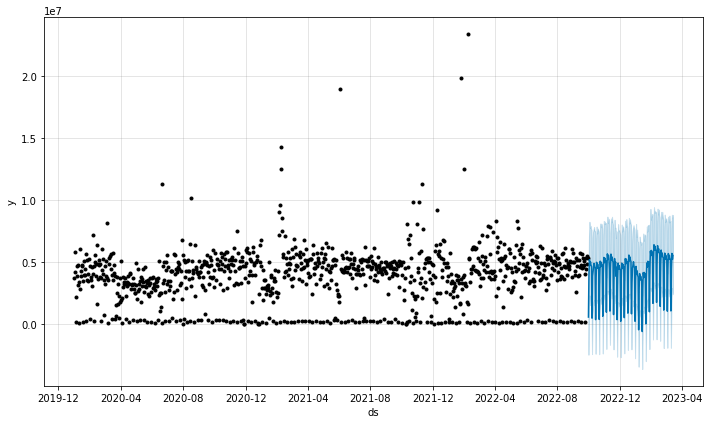

In [29]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [30]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-10-01,588586.56125
2022-10-02,3991101.59658
2022-10-03,5212977.92555
2022-10-04,4729933.60126
2022-10-05,5038264.77443


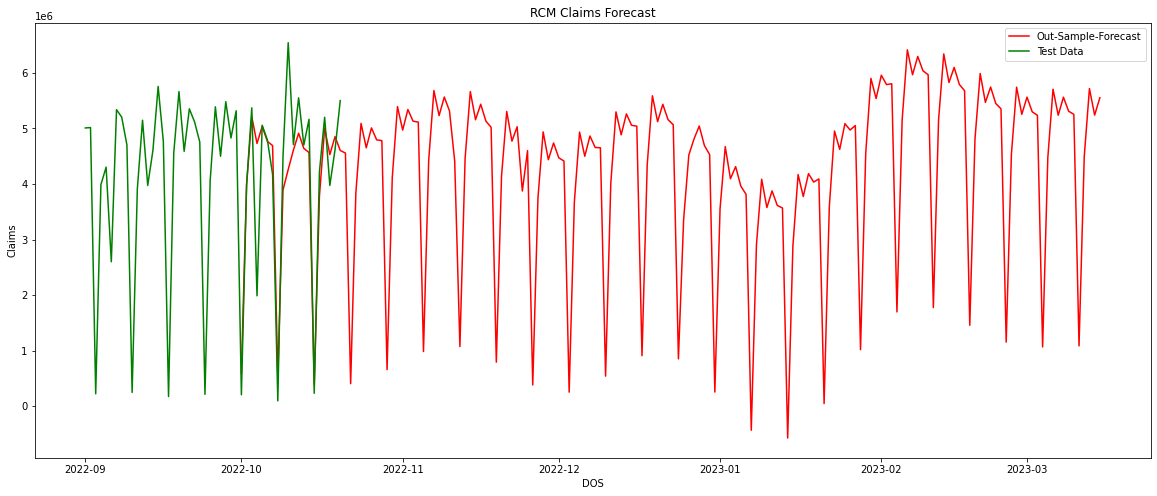

In [31]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [32]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [33]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(1000)

,ds,yhat,y,diff
0,2022-10-01,588586.56125,203977.00000,384609.56125
1,2022-10-02,3991101.59658,3980991.00000,10110.59658
2,2022-10-03,5212977.92555,5371517.00000,158539.07445
3,2022-10-04,4729933.60126,1985972.00000,2743961.60126
4,2022-10-05,5038264.77443,5058575.00000,20310.22557
...,...,...,...,...
161,2023-03-11,1083743.73227,NaN,NaN
162,2023-03-12,4491555.60067,NaN,NaN
163,2023-03-13,5718690.94014,NaN,NaN
164,2023-03-14,5240556.54612,NaN,NaN


In [34]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
(predicted/original)*100

706933924.1211168 80572019.0


877.3938308795723

In [35]:
original-predicted

-626361905.1211168

In [36]:
def DUMP_DATA(d,forecast_section,pracice_code):
    data_to_dump=d[['yhat','ds']]
    data_to_dump['PRACTICE_CODE']=pracice_code
    data_to_dump['FORECAST_TYPE']=forecast_section
    data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

    con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
                         ,host='172.16.0.168',database='AmazingDb',autocommit = True)
    cur=con.cursor()
    for i, row in data_to_dump.iterrows():
        query="""
            insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
        values(%s,%s,%s,%s)
            """
        cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
    print('Data Inserted')
    con.close()

In [37]:
DUMP_DATA(d,'Overall_Submission_Charges', 0)

Data Inserted
